# BERT

In [3]:
# x_train, y_train, x_val, y_val, x_test, y_test
# train, val, test, mapping

import json
import os

# Function to load JSON from a file
def load_json(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# Function to load all JSONs (train, val, test, mapping) into respective variables
def load_all_jsons(folder_path):
    train = load_json(folder_path, "train.json")
    val = load_json(folder_path, "val.json")
    test = load_json(folder_path, "test.json")
    mapping = load_json(folder_path, "mapping.json")

    return train, val, test, mapping

# Example usage:
output_folder = "data/splits"
train, val, test, mapping = load_all_jsons(output_folder)



In [ ]:
!pip install transformers datasets evaluate accelerate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [7]:
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [8]:
from datasets import load_dataset, DatasetDict
import os

output_folder = "data/splits"

dataset = load_dataset('json', data_files={
    'train': os.path.join(output_folder, 'train.json'),
    'val': os.path.join(output_folder, 'val.json'),
    'test': os.path.join(output_folder, 'test.json')})

# Example: Print a few samples from each split
print("Train Dataset:", dataset['train'][:2])
print("Validation Dataset:", dataset['val'][:2])
print("Test Dataset:", dataset['test'][:2])


Train Dataset: {'text': ["peer counseling is advertised well. however, these are college aged peers. they don't know what they're doing. they should have a certification/program of some kind if they don't already", "i haven't used/not familiar with mental health services provided by the school."], 'label': [3, 0]}
Validation Dataset: {'text': ["im a rather new student so i can't say anything for certain. i can tell you that after being on campus for a semester, i know next to nothing about the mental health program here. i don't really need it (i seek counseling out of school) but it would be nice to know about for those that do. ", "i think some of the counselors are okay at what they do. they're not amazing, but i definitely feel comfortable with them "], 'label': [3, 1]}
Test Dataset: {'text': ['the habif mental health staff need more attention. there is such little staff that appointments are rare. uncle joes is a good resource but students shouldn’t have to rely on peers due to in

In [9]:
train_dataset = dataset['train']
eval_dataset = dataset['val']

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1165.89 examples/s]


In [ ]:
import numpy as np
import evaluate

precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    return {
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }


## without lora

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels = 4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_folder = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/without_lora_4/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

training_args = TrainingArguments(output_dir=output_folder,
                                  learning_rate=3e-5,
                                  # Reduce the batch size if you don't have enough memory
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  num_train_epochs=6,
                                  weight_decay=0.02,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,)
bert_peft_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, # training dataset requires column input_ids
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
)
bert_peft_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.920393,0.666667
2,No log,1.041720,0.717949
3,No log,1.089028,0.743590
4,0.570700,1.156469,0.743590
5,0.570700,1.100722,0.743590
6,0.570700,1.091900,0.717949


TrainOutput(global_step=894, training_loss=0.3354663678196986, metrics={'train_runtime': 428.9666, 'train_samples_per_second': 8.294, 'train_steps_per_second': 2.084, 'total_flos': 936165945581568.0, 'train_loss': 0.3354663678196986, 'epoch': 6.0})

In [ ]:
peft_bert_model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/without_peft_4/"
model.save_pretrained(peft_bert_model_path)

# check the size of the saved model
for file_name in os.listdir(peft_bert_model_path):
    file_size = os.path.getsize(peft_bert_model_path + file_name)
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: config.json; File Size: 0.90KB
File Name: model.safetensors; File Size: 423121.99KB


### inference

In [ ]:
model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/without_peft_4/"

pred_model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                      num_labels=4)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

               precision    recall  f1-score   support

      neutral       0.89      0.42      0.57        19
    satisfied       0.45      0.62      0.52        21
         both       0.75      0.30      0.43        40
not-satisfied       0.70      0.92      0.79        79

     accuracy                           0.67       159
    macro avg       0.70      0.57      0.58       159
 weighted avg       0.70      0.67      0.64       159



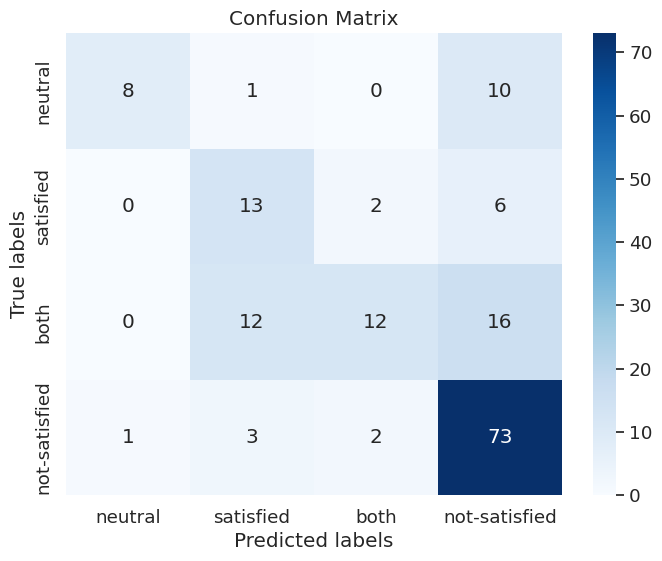

In [ ]:
# prompt: have the trainer predict and also np argmax to get the categories
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                      num_labels=4)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

import numpy as np
# Get predictions
raw_pred, _, _ = trainer.predict(tokenized_test_dataset)

# Convert logits to predicted classes
y_pred = np.argmax(raw_pred, axis=1)

# Assuming 'mapping' contains the mapping from class indices to labels
class_mapping_reverse = mapping['class_mapping_reverse']

# Print classification report
print(classification_report(np.asarray(test_dataset['label']), y_pred, target_names=['neutral', 'satisfied', 'both', 'not-satisfied']))

# Plot confusion matrix
cm = confusion_matrix(test_dataset['label'], y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'both', 'not-satisfied'])


In [ ]:
test_predictions

{'eval_loss': 0.8506799936294556,
 'eval_precision': 0.6956007115489875,
 'eval_recall': 0.5660377208844898,
 'eval_f1': 0.5783695652173912,
 'eval_runtime': 5.2401,
 'eval_samples_per_second': 30.343,
 'eval_steps_per_second': 3.817}

## lora

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_name = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels = 4,
                                                           )

# Define LoRA Config
lora_config = LoraConfig(
 r=256,
 lora_alpha=512,
 target_modules=["query", "value"],
 lora_dropout=0.1,
 bias="none",
 task_type=TaskType.SEQ_CLS, # this is necessary
 inference_mode=True
)

# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # see % trainable parameters

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,076 || all params: 117,753,608 || trainable%: 0.0026


In [ ]:
output_folder = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/lora_6"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

training_args = TrainingArguments(output_dir=output_folder,
                                  learning_rate=7e-4,
                                  # Reduce the batch size if you don't have enough memory
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  num_train_epochs=10,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,)
bert_peft_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, # training dataset requires column input_ids
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
)
bert_peft_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.230328,0.512821
2,No log,1.316871,0.487179
3,No log,1.208278,0.487179
4,1.255200,1.373799,0.487179
5,1.255200,1.202555,0.435897
6,1.255200,1.198670,0.487179
7,1.207000,1.179699,0.461538
8,1.207000,1.182271,0.487179
9,1.207000,1.168071,0.487179
10,1.207000,1.167617,0.487179


TrainOutput(global_step=1490, training_loss=1.2083891798185822, metrics={'train_runtime': 239.0495, 'train_samples_per_second': 24.807, 'train_steps_per_second': 6.233, 'total_flos': 1732249414778880.0, 'train_loss': 1.2083891798185822, 'epoch': 10.0})

In [ ]:
peft_bert_model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/peft_6/"
model.save_pretrained(peft_bert_model_path)

# check the size of the saved model
for file_name in os.listdir(peft_bert_model_path):
    file_size = os.path.getsize(peft_bert_model_path + file_name)
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: README.md; File Size: 4.97KB
File Name: adapter_model.safetensors; File Size: 36882.98KB
File Name: adapter_config.json; File Size: 0.65KB


In [ ]:
# load PEFT model and predict
from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model

peft_bert_model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/peft_5/"

config = PeftConfig.from_pretrained(peft_bert_model_path)
pred_model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=4)
pred_model = PeftModel.from_pretrained(pred_model, peft_bert_model_path)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Undefined

               precision    recall  f1-score   support

      neutral       0.71      0.26      0.38        19
    satisfied       0.00      0.00      0.00        21
         both       0.33      0.03      0.05        40
not-satisfied       0.51      0.96      0.67        79

     accuracy                           0.52       159
    macro avg       0.39      0.31      0.27       159
 weighted avg       0.42      0.52      0.39       159



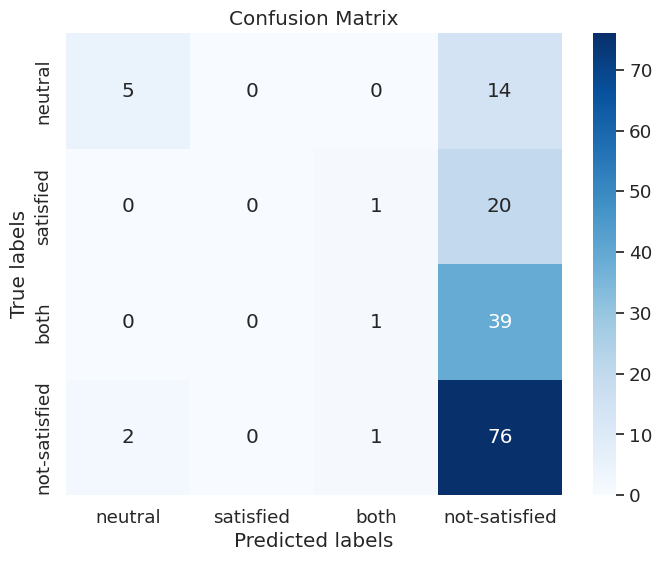

In [ ]:
# prompt: have the trainer predict and also np argmax to get the categories
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# load PEFT model and predict
from peft import PeftModel, PeftConfig, LoraConfig, TaskType, get_peft_model

peft_bert_model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/peft_5/"

config = PeftConfig.from_pretrained(peft_bert_model_path)
pred_model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=4)
pred_model = PeftModel.from_pretrained(pred_model, peft_bert_model_path)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

import numpy as np
# Get predictions
raw_pred, _, _ = trainer.predict(tokenized_test_dataset)

# Convert logits to predicted classes
y_pred = np.argmax(raw_pred, axis=1)

# Assuming 'mapping' contains the mapping from class indices to labels
class_mapping_reverse = mapping['class_mapping_reverse']

# Print classification report
print(classification_report(np.asarray(test_dataset['label']), y_pred, target_names=['neutral', 'satisfied', 'both', 'not-satisfied']))

# Plot confusion matrix
cm = confusion_matrix(test_dataset['label'], y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'both', 'not-satisfied'])


In [ ]:
test_predictions

{'eval_loss': 1.0317108631134033,
 'eval_precision': 0.38942154042825183,
 'eval_recall': 0.3125458027981346,
 'eval_f1': 0.274448419797257,
 'eval_runtime': 4.731,
 'eval_samples_per_second': 33.608,
 'eval_steps_per_second': 4.227}

# CustomBERT

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, BertConfig, BertModel

class CustomBERT(BertForSequenceClassification):
    def __init__(self, config, extra_hidden_size=512):
        super(CustomBERT, self).__init__(config)

        # Load pre-trained BERT model
        self.bert = BertModel(config)

        # Define additional layers
        self.extra_layer1 = nn.Linear(config.hidden_size, extra_hidden_size)
        self.extra_layer2 = nn.Linear(extra_hidden_size, config.hidden_size)

        # Re-define the classification head with the original size
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout (optional, for regularization)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        # Forward pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Extract the pooled output (this is the [CLS] token output)
        pooled_output = outputs[1]  # This is the [CLS] token output

        # Pass through the additional layers
        x = self.extra_layer1(pooled_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.extra_layer2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Final classification
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        # Return loss if labels are provided, otherwise return logits
        return (loss, logits) if loss is not None else logits


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model_name = "bert-base-cased"
model = CustomBERT.from_pretrained(model_name, num_labels = 4)

Some weights of CustomBERT were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'extra_layer1.bias', 'extra_layer1.weight', 'extra_layer2.bias', 'extra_layer2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
output_folder = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/custom_without_lora_3/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

training_args = TrainingArguments(output_dir=output_folder,
                                  learning_rate=3e-5,
                                  # Reduce the batch size if you don't have enough memory
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  num_train_epochs=10,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  lr_scheduler_type=transformers.get_cosine_with_hard_restarts_schedule_with_warmup(transformers.AdamW, 100, 100),)
bert_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, # training dataset requires column input_ids
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
)
bert_trainer.train()

AttributeError: type object 'AdamW' has no attribute 'param_groups'

In [ ]:
bert_model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/custom_without_peft_3/"
model.save_pretrained(bert_model_path)

# check the size of the saved model
for file_name in os.listdir(bert_model_path):
    file_size = os.path.getsize(bert_model_path + file_name)
    print(f"File Name: {file_name}; File Size: {file_size / 1024:.2f}KB")

File Name: config.json; File Size: 0.83KB
File Name: model.safetensors; File Size: 426199.34KB


In [ ]:
model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/custom_without_peft_2/"

pred_model = CustomBERT.from_pretrained(model_path, num_labels=4)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

               precision    recall  f1-score   support

      neutral       0.88      0.74      0.80        19
    satisfied       0.68      0.71      0.70        21
         both       0.62      0.70      0.66        40
not-satisfied       0.88      0.85      0.86        79

     accuracy                           0.78       159
    macro avg       0.77      0.75      0.76       159
 weighted avg       0.79      0.78      0.78       159



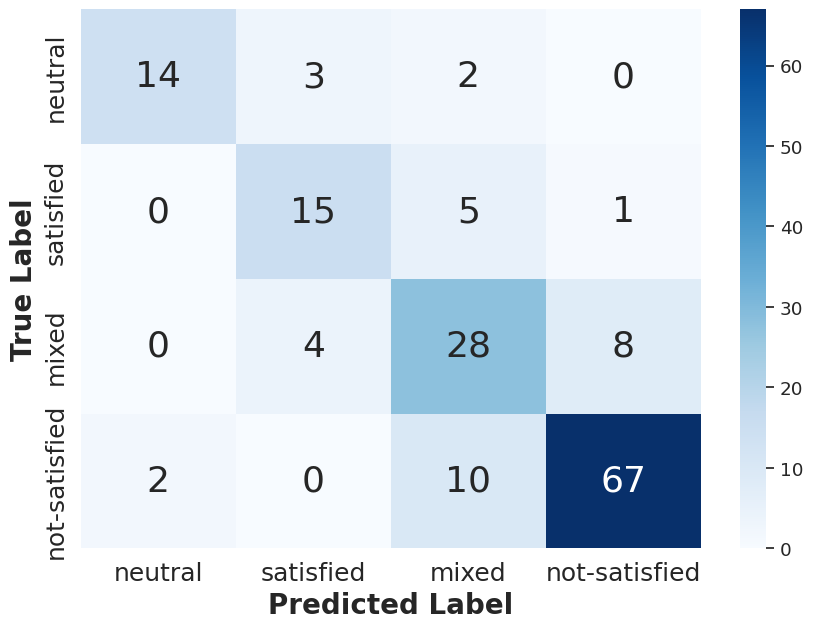

In [ ]:
# prompt: have the trainer predict and also np argmax to get the categories
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import Trainer

model_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/bert/custom_without_peft_2/"

pred_model = CustomBERT.from_pretrained(model_path, num_labels=4)

trainer = Trainer(
    model=pred_model,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

test_dataset = dataset['test']
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

test_predictions = trainer.evaluate(tokenized_test_dataset)

# def plot_confusion_matrix(cm, labels):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)
#     sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title('Confusion Matrix')
#     plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 26})  # Increase font size here
    plt.xlabel('Predicted Label', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=18)  # Increase x-axis tick label size and make bold
    plt.yticks(fontsize=18)  # Increase y-axis tick label size and make bold

    plt.show()
import numpy as np
# Get predictions
raw_pred, _, _ = trainer.predict(tokenized_test_dataset)

# Convert logits to predicted classes
y_pred = np.argmax(raw_pred, axis=1)

# Assuming 'mapping' contains the mapping from class indices to labels
class_mapping_reverse = mapping['class_mapping_reverse']

# Print classification report
print(classification_report(np.asarray(test_dataset['label']), y_pred, target_names=['neutral', 'satisfied', 'both', 'not-satisfied']))

# Plot confusion matrix
cm = confusion_matrix(test_dataset['label'], y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'mixed', 'not-satisfied'])


In [ ]:
test_predictions

{'eval_loss': 0.8188726902008057,
 'eval_precision': 0.7651548378522062,
 'eval_recall': 0.7498072713429142,
 'eval_f1': 0.7552535192621685,
 'eval_runtime': 4.5193,
 'eval_samples_per_second': 35.182,
 'eval_steps_per_second': 4.425}